# Parameter Definition

In [41]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import random
#from skimage import color, exposure

# ======================================================================
# Parameters Definition
# ======================================================================
color_channel = False
hist_channel = False
# Size of reduced image
size_reduced = 16
# Number of bins
nbins = 32
# ======================================================================
# HOG parameters
hog_channel = "ALL"
#colorspace = 'HSV'
#orient = 9
#pix_per_cell = 8
#cell_per_block = 2
# ======================================================================
colorspace = 'YCrCb'
orient = 11 
pix_per_cell = 16 
cell_per_block = 2
# ======================================================================
# Dataset size
num_samples = None

# Read in Data

In [42]:
# ======================================================================
# Read in Data
# ======================================================================
path_cars = 'training_data/vehicles'
path_notcars = 'training_data/non-vehicles'
cars = []
notcars = []
# Loop through training data folder
for root, dirs, files in os.walk(path_cars):
    for name in files:
        if name.endswith('.jpeg') or name.endswith('.png'):
            filepath = os.path.join(root, name)
            cars.append(filepath)
for root, dirs, files in os.walk(path_notcars):
    for name in files:
        if name.endswith('.jpeg') or name.endswith('.png'):
            filepath = os.path.join(root, name)
            notcars.append(filepath)
#random.shuffle(notcars)
cars = cars[:num_samples]
notcars = notcars[:num_samples]

# Function Definition

In [43]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""
    # Create figure and 3D axes
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)
    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')
    return ax  # return Axes3D object for further manipulation
                
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list) # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_notcars"] = len(notcar_list) # Define a key "n_notcars" and store the number of notcar images
    example_img = cv2.imread(car_list[0]) # Read in a test image, either car or notcar
    example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
    data_dict["car_img_channel_0_max"] = np.amax(example_img[:,:,0])
    data_dict["car_img_channel_1_max"] = np.amax(example_img[:,:,1])
    data_dict["car_img_channel_2_max"] = np.amax(example_img[:,:,2])
    example_img = cv2.imread(notcar_list[0]) # Read in a test image, either car or notcar
    example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
    data_dict["notcar_img_channel_0_max"] = np.amax(example_img[:,:,0])
    data_dict["notcar_img_channel_1_max"] = np.amax(example_img[:,:,1])
    data_dict["notcar_img_channel_2_max"] = np.amax(example_img[:,:,2])
    data_dict["image_shape"] = example_img.shape
    data_dict["data_type"] = example_img.dtype
    return data_dict

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def color_hls_hist(img, nbins=32, bins_range=(0, 256)):
    img_feature = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Compute the histogram of the color channels separately
    #channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    #channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img_feature[:,:,2], bins=nbins, range=bins_range)
    #print(len(channel3_hist))
    # Concatenate the histograms into a single feature vector
    #hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel3_hist[0]

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,\
        pixels_per_cell=(pix_per_cell, pix_per_cell), \
        cells_per_block=(cell_per_block, cell_per_block), \
        visualise=True, feature_vector=feature_vec)
        #features = [] # Remove this line
        #hog_image = img # Remove this line
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,\
        pixels_per_cell=(pix_per_cell, pix_per_cell), \
        cells_per_block=(cell_per_block, cell_per_block), \
        visualise=False, feature_vector=feature_vec)
        #features = [] # Remove this line
        return features

# Data Checking and Visualization

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8
Car Image Channel Max:  190 192 176
NotCar Image Channel Max:  148 167 207


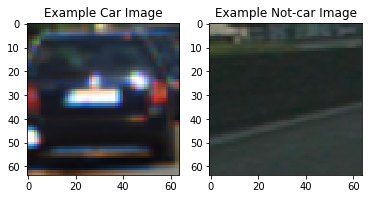

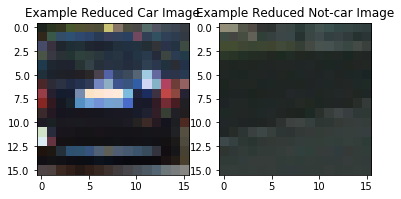

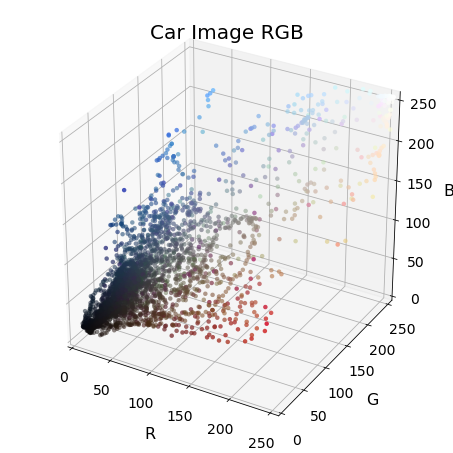

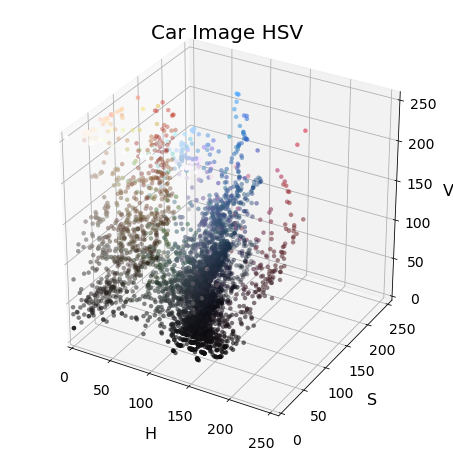

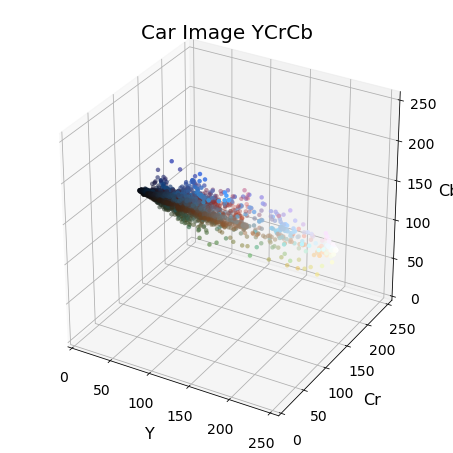

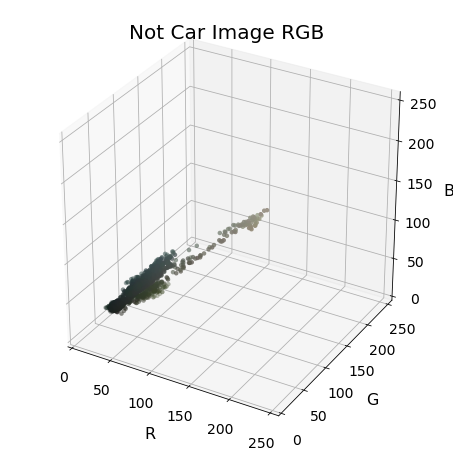

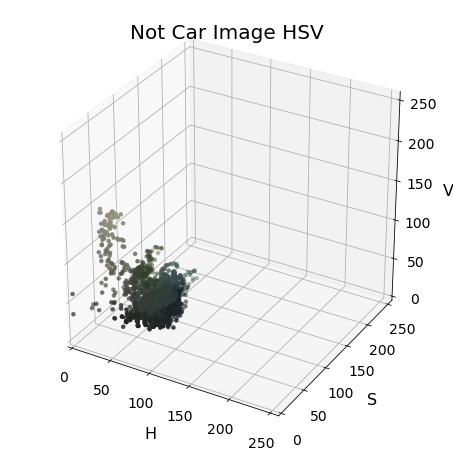

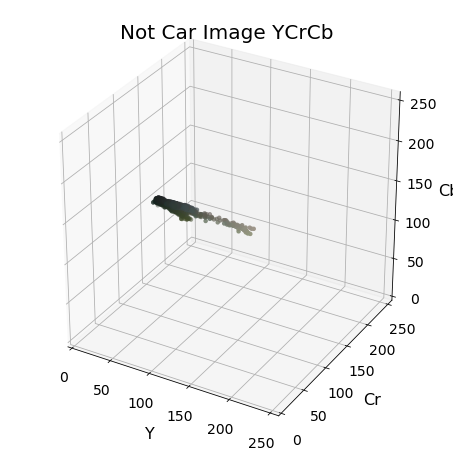

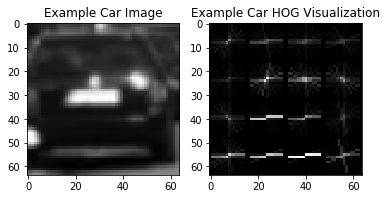

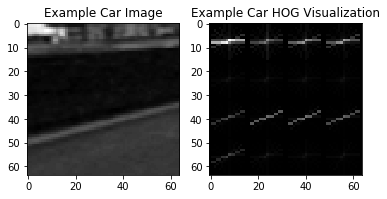

In [44]:
# ======================================================================
# Data Look
# ======================================================================
data_info = data_look(cars, notcars)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
print('Car Image Channel Max: ',data_info["car_img_channel_0_max"], data_info["car_img_channel_1_max"],\
      data_info["car_img_channel_2_max"])
print('NotCar Image Channel Max: ',data_info["notcar_img_channel_0_max"], data_info["notcar_img_channel_1_max"],\
      data_info["notcar_img_channel_2_max"])
# ======================================================================
# Plot Example Images
# ======================================================================
# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB)
#car_image = car_image/255.0
#print("PNG after scaling by 255: ",np.amax(notcar_image[:,:,0]),np.amax(notcar_image[:,:,1]),np.amax(notcar_image[:,:,2]))
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()
# ======================================================================
# Plot REDUCED Example Images
# ======================================================================
car_image_reduced = cv2.resize(car_image, (size_reduced, size_reduced))
notcar_image_reduced = cv2.resize(notcar_image, (size_reduced, size_reduced))
#print("PNG after scaling by 255 and Reduced: ",np.amax(notcar_image_reduced[:,:,0]),np.amax(notcar_image_reduced[:,:,1]),\
#      np.amax(notcar_image_reduced[:,:,2]))
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image_reduced)
plt.title('Example Reduced Car Image')
plt.subplot(122)
plt.imshow(notcar_image_reduced)
plt.title('Example Reduced Not-car Image')
plt.show()
# ======================================================================
# Plot COLOR SPACE of Example Images
# ======================================================================
# Select a small fraction of pixels to plot by subsampling it
scale = max(car_image.shape[0], car_image.shape[1], 64) / 64  # at most 64 rows and columns
car_image_small = cv2.resize(car_image, (np.int(car_image.shape[1] / scale), np.int(car_image.shape[0] / scale)), \
                             interpolation=cv2.INTER_NEAREST)
scale = max(notcar_image.shape[0], notcar_image.shape[1], 64) / 64  # at most 64 rows and columns
notcar_image_small = cv2.resize(notcar_image, (np.int(notcar_image.shape[1] / scale), np.int(notcar_image.shape[0] / scale)), \
                             interpolation=cv2.INTER_NEAREST)
# Convert subsampled image to desired color space(s)
car_image_small_YCrCb = cv2.cvtColor(car_image_small, cv2.COLOR_RGB2YCrCb)
notcar_image_small_YCrCb = cv2.cvtColor(notcar_image_small, cv2.COLOR_RGB2YCrCb)
car_image_small_HSV = cv2.cvtColor(car_image_small, cv2.COLOR_RGB2HSV)
notcar_image_small_HSV = cv2.cvtColor(notcar_image_small, cv2.COLOR_RGB2HSV)
car_image_small_rgb = car_image_small / 255.  # scaled to [0, 1], only for plotting
notcar_image_small_rgb = notcar_image_small / 255.  
# Plot and show color space
ax_1 = plot3d(car_image_small, car_image_small_rgb)
ax_1.set_title('Car Image RGB', fontsize=20)
ax_2 = plot3d(car_image_small_HSV, car_image_small_rgb, axis_labels=list(("H","S","V")))
ax_2.set_title('Car Image HSV', fontsize=20)
ax_3 = plot3d(car_image_small_YCrCb, car_image_small_rgb, axis_labels=list(("Y","Cr","Cb")))
ax_3.set_title('Car Image YCrCb', fontsize=20)
ax_4 = plot3d(notcar_image_small, notcar_image_small_rgb)
ax_4.set_title('Not Car Image RGB', fontsize=20)
ax_5 = plot3d(notcar_image_small_HSV, notcar_image_small_rgb, axis_labels=list(("H","S","V")))
ax_5.set_title('Not Car Image HSV', fontsize=20)
ax_6 = plot3d(notcar_image_small_YCrCb, notcar_image_small_rgb, axis_labels=list(("Y","Cr","Cb")))
ax_6.set_title('Not Car Image YCrCb', fontsize=20)
# ======================================================================
# Plot HOG of Example Images
# ======================================================================
car_image_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(car_image_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image_gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('Example Car HOG Visualization')
plt.show()
notcar_image_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(notcar_image_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
fig = plt.figure()
plt.subplot(121)
plt.imshow(notcar_image_gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('Example Car HOG Visualization')
plt.show()


# Feature Extraction and Normalization

Started Feature Extraction ...
Completed Feature Extraction ...
Shape of X:  (17760, 1188) Shape of scaled_X:  (17760, 1188)
1.0 0.0
5.04926243521 9.98690560189


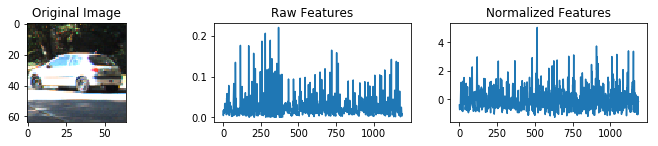

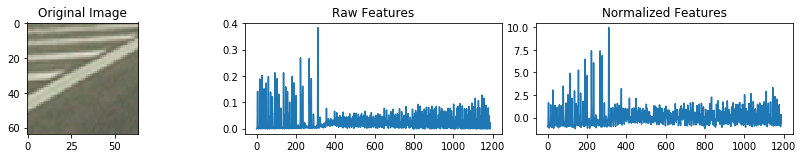

In [45]:
# ======================================================================
# Feature Extraction of Color Space and HOG
# ======================================================================
def get_features(imgs, orient, pix_per_cell, cell_per_block, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img_file in imgs:
        # Read in each one by one
        img_temp = cv2.imread(img_file)
        if cspace == 'RGB':
            img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB)
        elif cspace == 'YUV':
            img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2YUV)
        elif cspace == 'YCrCb':
            img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2YCrCb)
        # Apply color_hist() to get color histogram features
        if hist_channel is True:
            hist_features = color_hist(img_temp, nbins = hist_bins, bins_range = hist_range)
        # Apply bin_spatial() to get spatial color features
        if color_channel is True:
            img_features = bin_spatial(img_temp, size = spatial_size)
        # Apply get_hog_features() to get HOG features
        img_ch1 = img_temp[:,:,0]
        img_ch2 = img_temp[:,:,1]
        img_ch3 = img_temp[:,:,2]
        hog_feat1 = get_hog_features(img_ch1, orient, pix_per_cell, cell_per_block, feature_vec=True)
        hog_feat2 = get_hog_features(img_ch2, orient, pix_per_cell, cell_per_block, feature_vec=True)
        hog_feat3 = get_hog_features(img_ch3, orient, pix_per_cell, cell_per_block, feature_vec=True)
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        # Append the new feature vector to the features list
        if (hist_channel is True) and (color_channel is True):
            features.append(np.concatenate((img_features, hist_features,hog_features)))
        else:
            features.append(hog_features)
    # Return list of feature vectors
    return features

print('Started Feature Extraction ...')
car_features = get_features(cars, orient, pix_per_cell, cell_per_block, cspace=colorspace, spatial_size=(size_reduced, size_reduced),
                        hist_bins=nbins, hist_range=(0, 256))
notcar_features = get_features(notcars, orient, pix_per_cell, cell_per_block, cspace=colorspace, spatial_size=(size_reduced, size_reduced),
                        hist_bins=nbins, hist_range=(0, 256))
print('Completed Feature Extraction ...')
car_label = np.ones(len(cars))
notcar_label = np.zeros(len(notcars))
y = np.hstack((car_label, notcar_label))
#print(car_features[0].shape)
#print(notcar_features[0].shape)
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    print("Shape of X: ", X.shape, "Shape of scaled_X: ", scaled_X.shape)
else: 
    print('Your function only returns empty feature vectors...')
    
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
print(y[car_ind], y[notcar_ind+len(cars)])
print(np.amax(scaled_X[car_ind]), np.amax(scaled_X[notcar_ind+len(cars)]))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(231)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(232)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(233)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig = plt.figure(figsize=(12,4))
plt.subplot(234)
plt.imshow(mpimg.imread(notcars[notcar_ind]))
plt.title('Original Image')
plt.subplot(235)
plt.plot(X[notcar_ind+len(cars)])
plt.title('Raw Features')
plt.subplot(236)
plt.plot(scaled_X[notcar_ind+len(cars)])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()

# Training Classifier

In [46]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
import time

print('The scikit-learn version is {}.'.format(sklearn.__version__))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#clf = SVC(kernel="linear")
clf = LinearSVC()
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
print('Test Accuracy of SVC = ', acc)
n_predict = 10
print('My SVC predicts: ',pred[0:n_predict])
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

The scikit-learn version is 0.18.1.
1.14 Seconds to train SVC...
Test Accuracy of SVC =  0.987331081081
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]


# HOG SubSampling and Heat Mapping

In [47]:
# ======================================================================
# Feature Extraction
# ======================================================================
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space = 'YCrCb'):
    
    bbox_list = []
    
    draw_img = np.copy(img)
    if color_space == 'YUV':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        
    #img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = img_tosearch
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    #plt.imshow(ctrans_tosearch)
    #plt.show()
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if hist_channel is True:
                hist_features = color_hist(subimg, nbins=hist_bins)
            if color_channel is True:
                spatial_features = bin_spatial(subimg, size=spatial_size)

            # Scale features and make a prediction
            if (hist_channel is True) and (color_channel is True):
                test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            else:
                test_features = hog_features.reshape(1, -1)
            test_features = X_scaler.transform(test_features)    
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bbox_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bbox_list
# ======================================================================
# Heat Map Functions
# ======================================================================
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
def apply_threshold(heatmap, threshold, mask):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    heatmap[mask < 1] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Pipeline Function

./test_images\test0.jpg


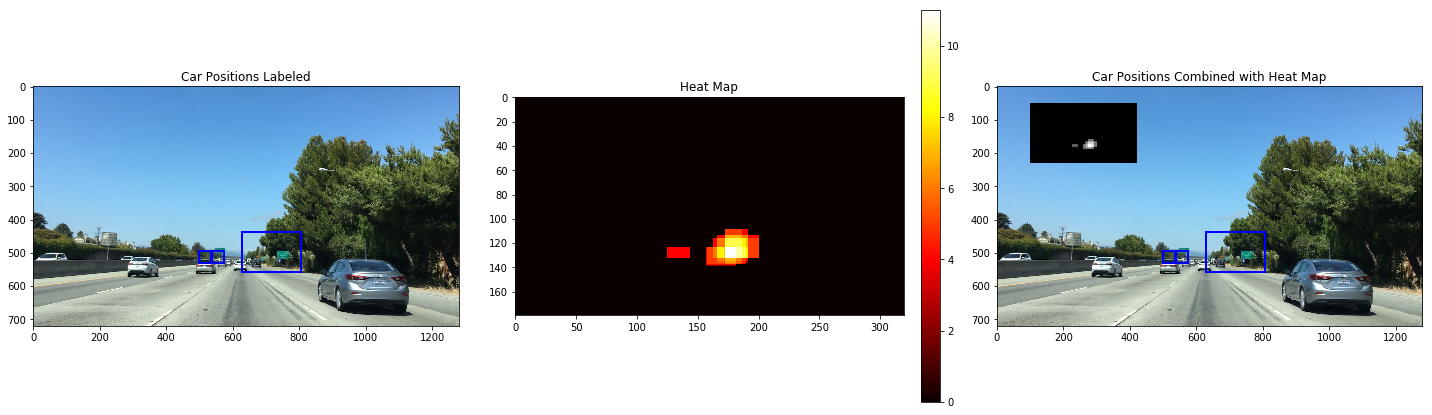

./test_images\test1.jpg


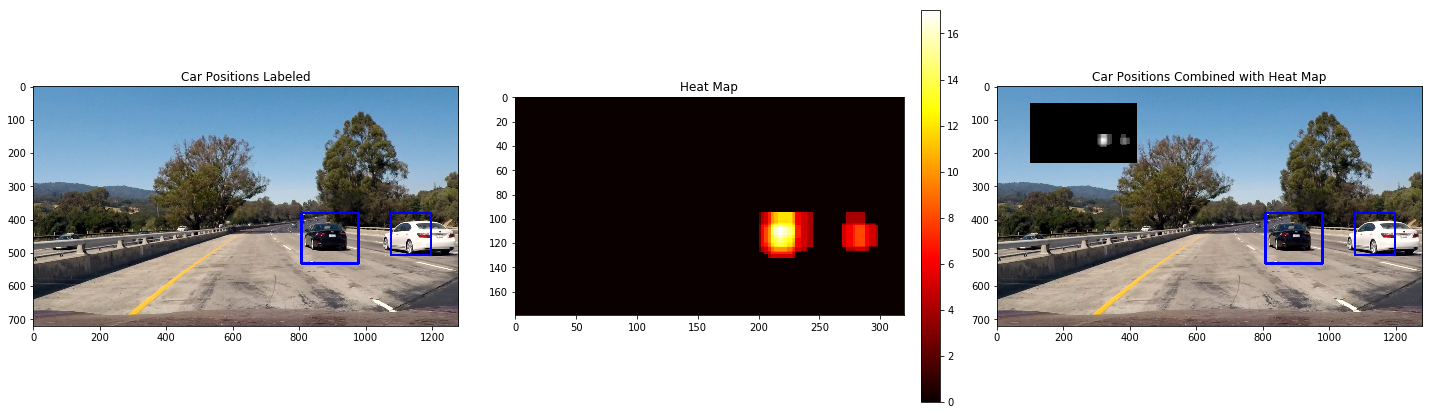

./test_images\test10.jpg


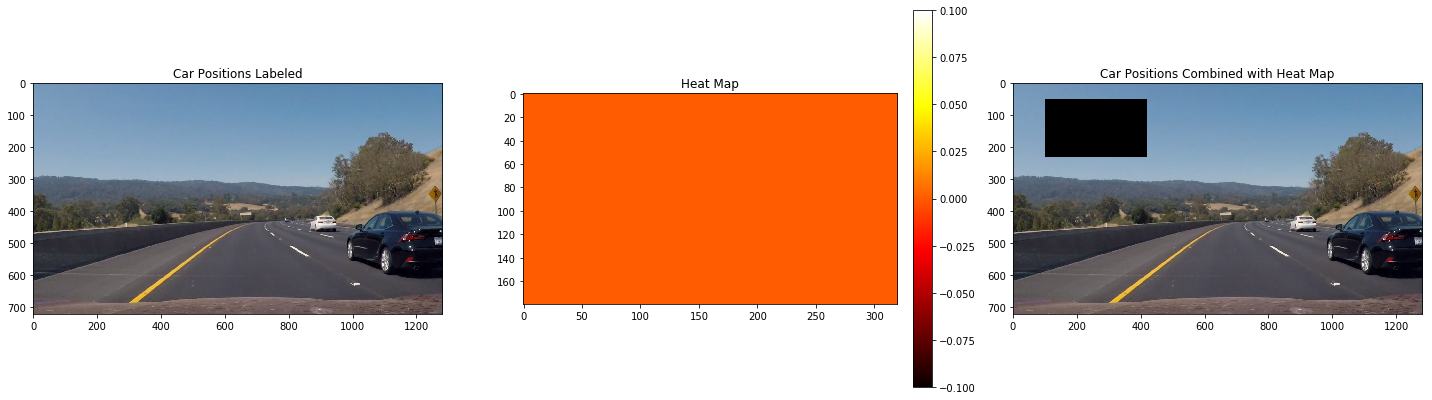

./test_images\test11.jpg


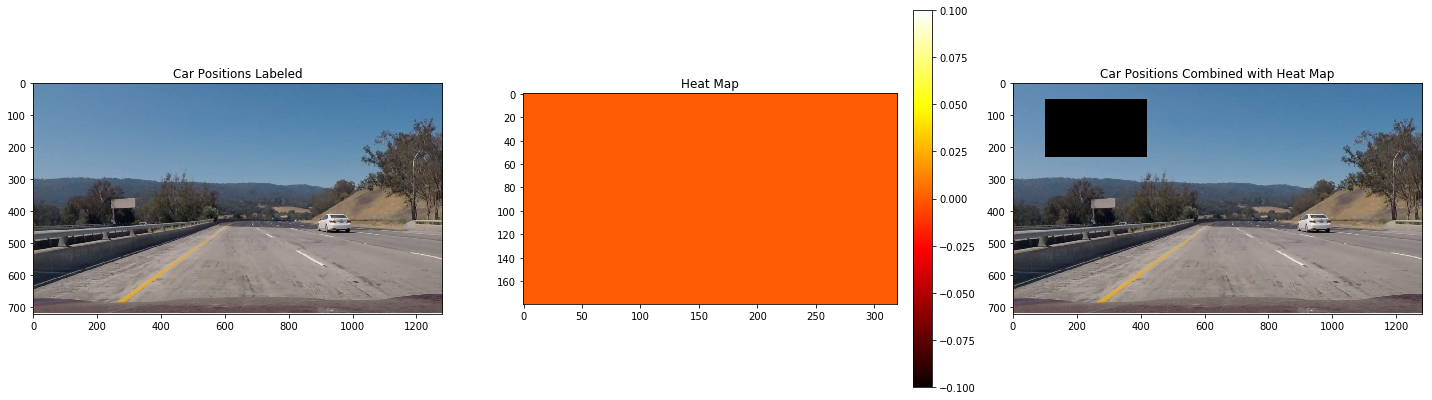

./test_images\test12.jpg


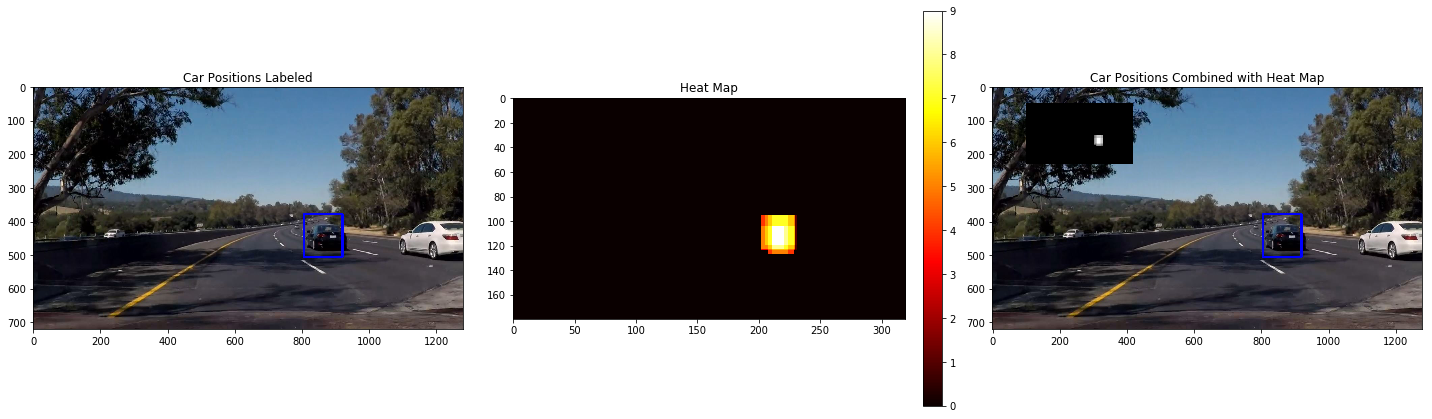

./test_images\test13.jpg


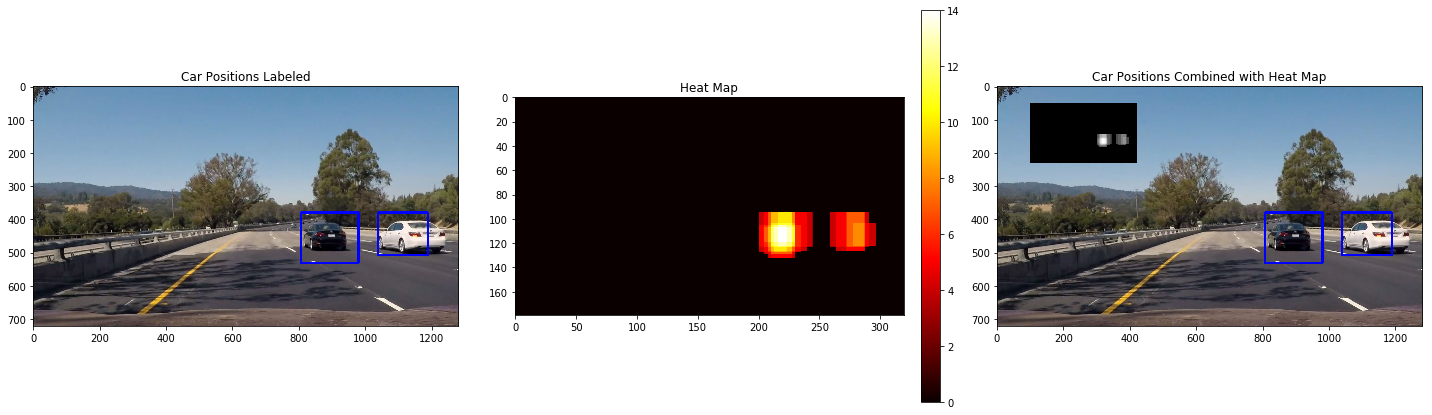

./test_images\test14.jpg


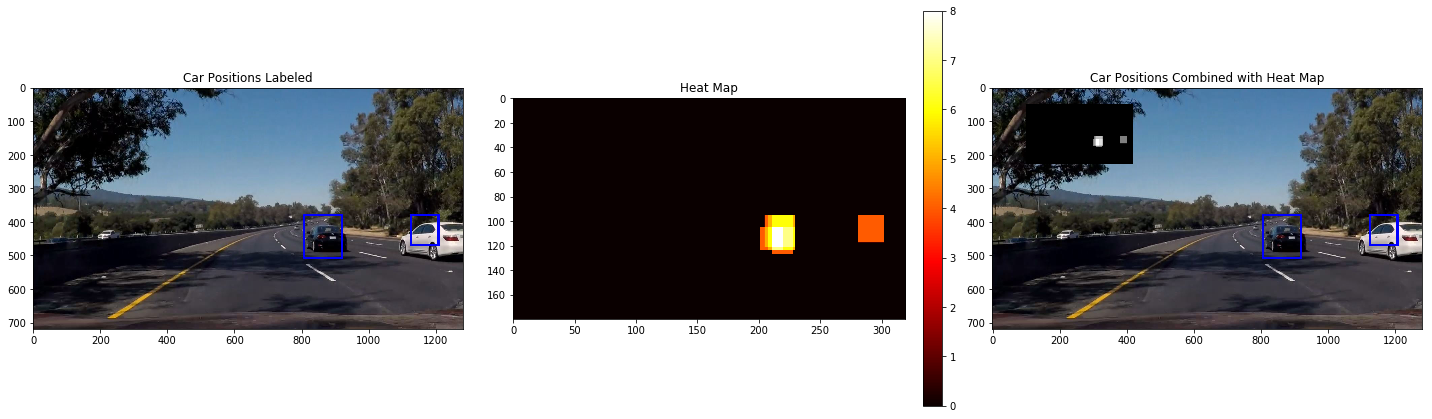

./test_images\test15.jpg


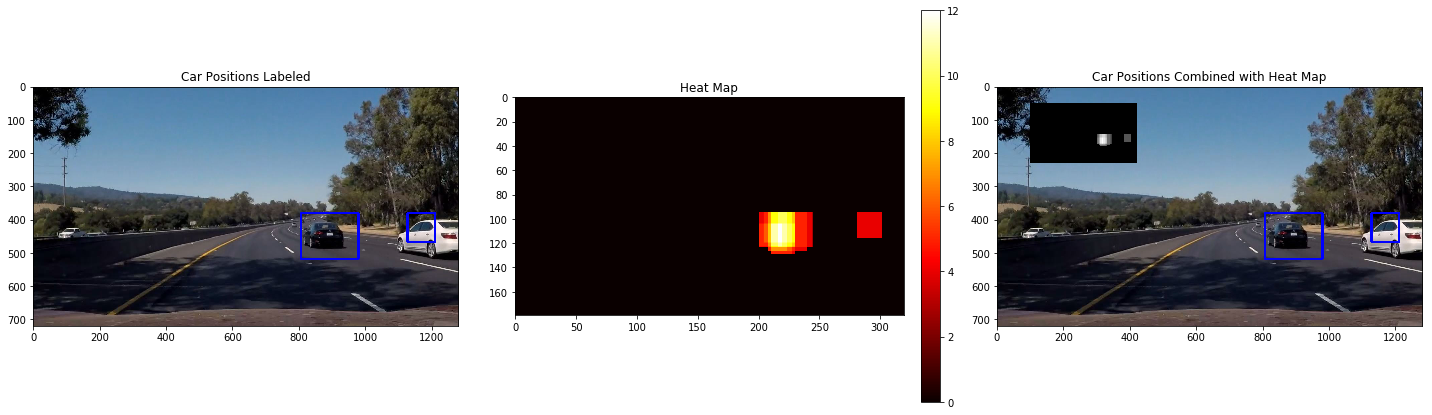

./test_images\test16.jpg


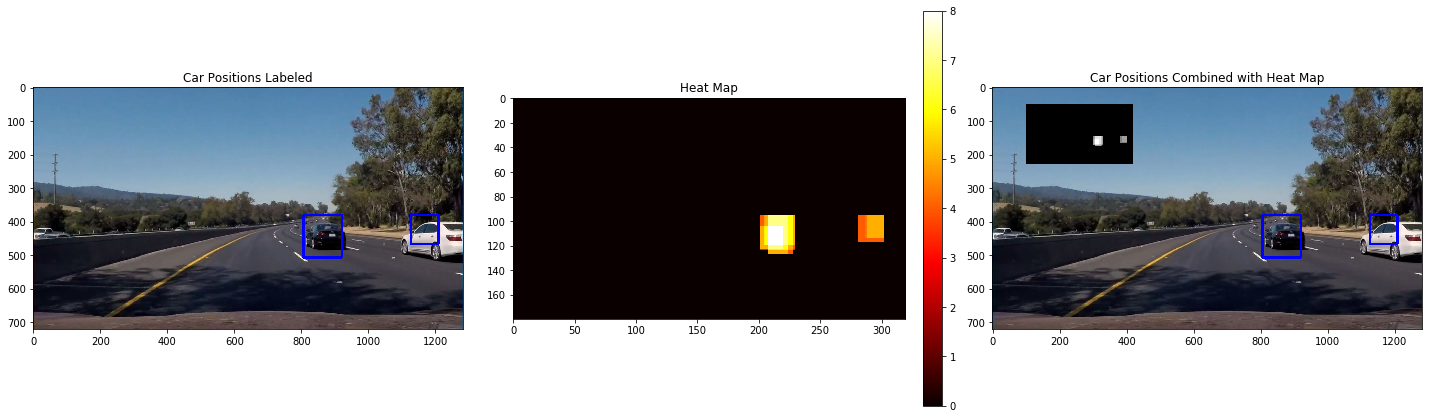

./test_images\test17.jpg


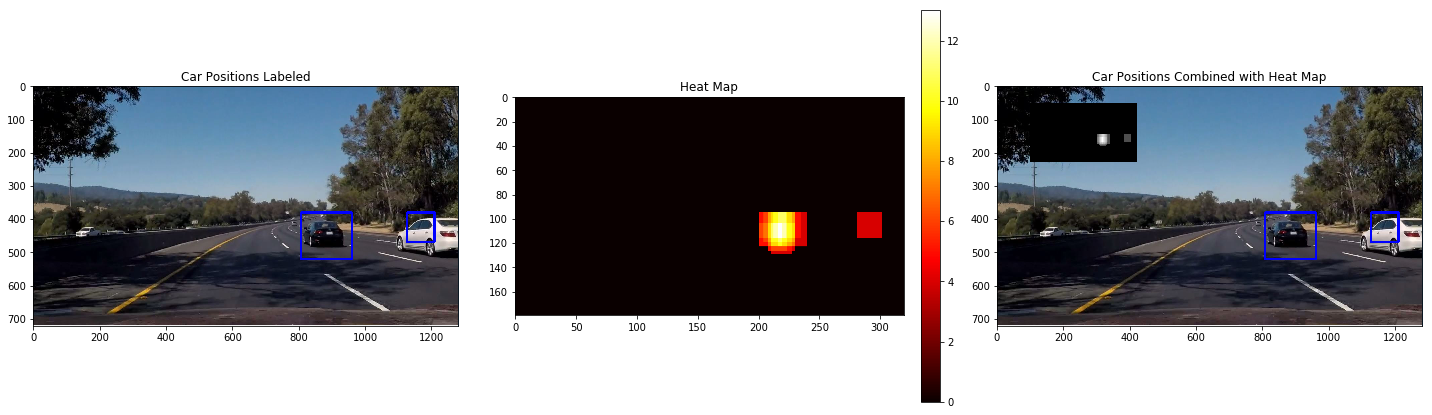

./test_images\test18.jpg


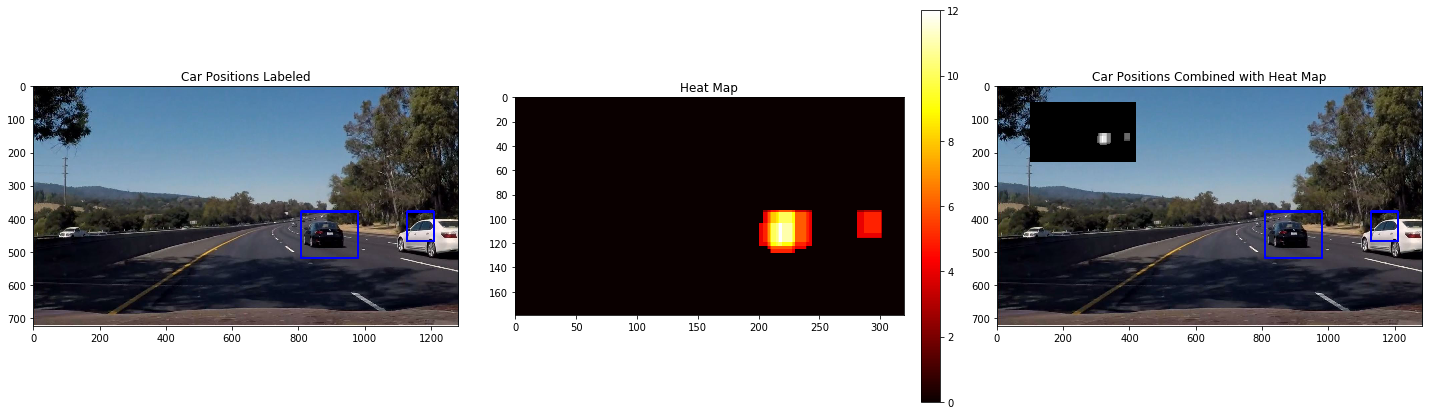

./test_images\test2.jpg


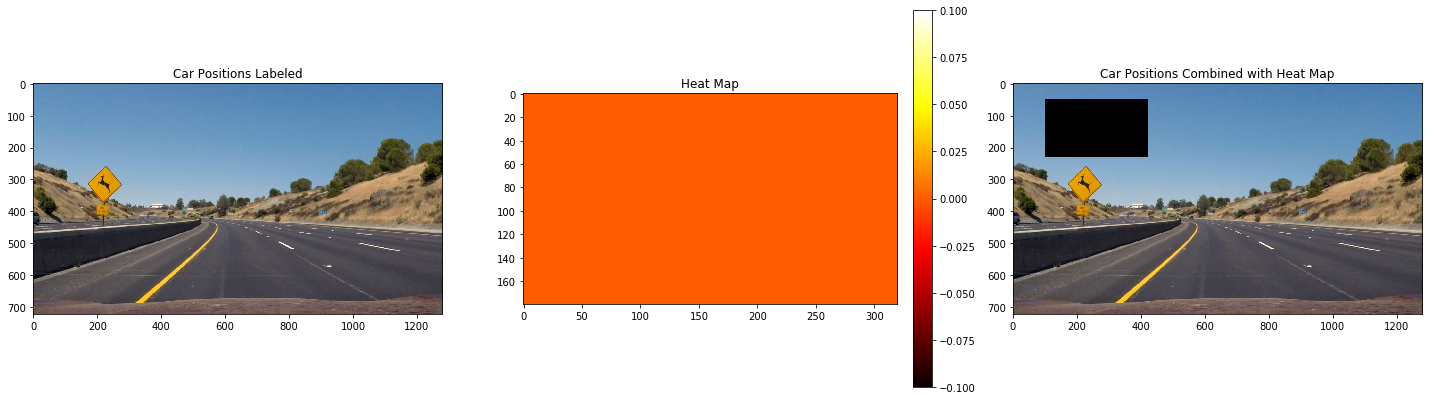

./test_images\test3.jpg


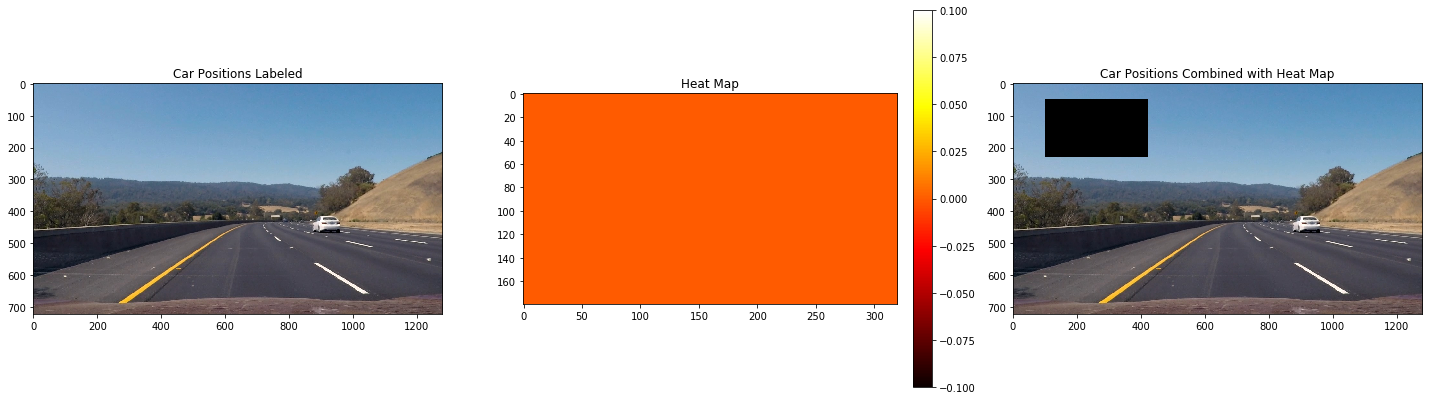

./test_images\test4.jpg


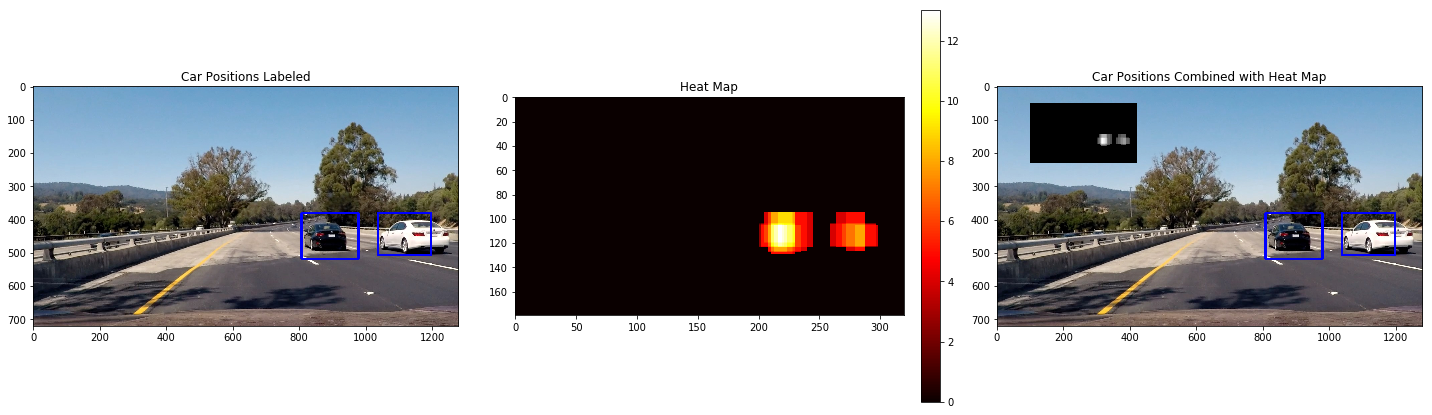

./test_images\test5.jpg


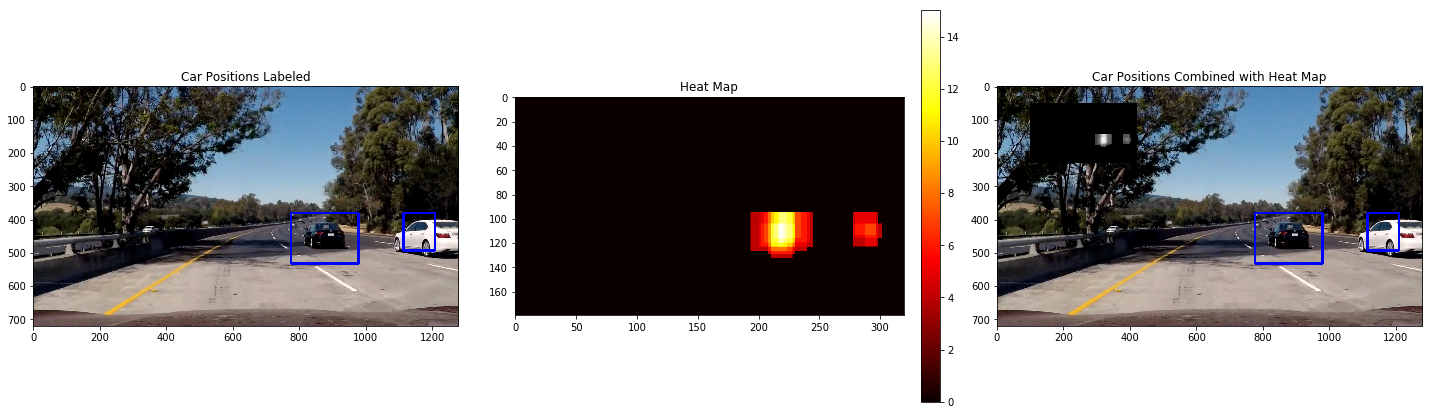

./test_images\test6.jpg


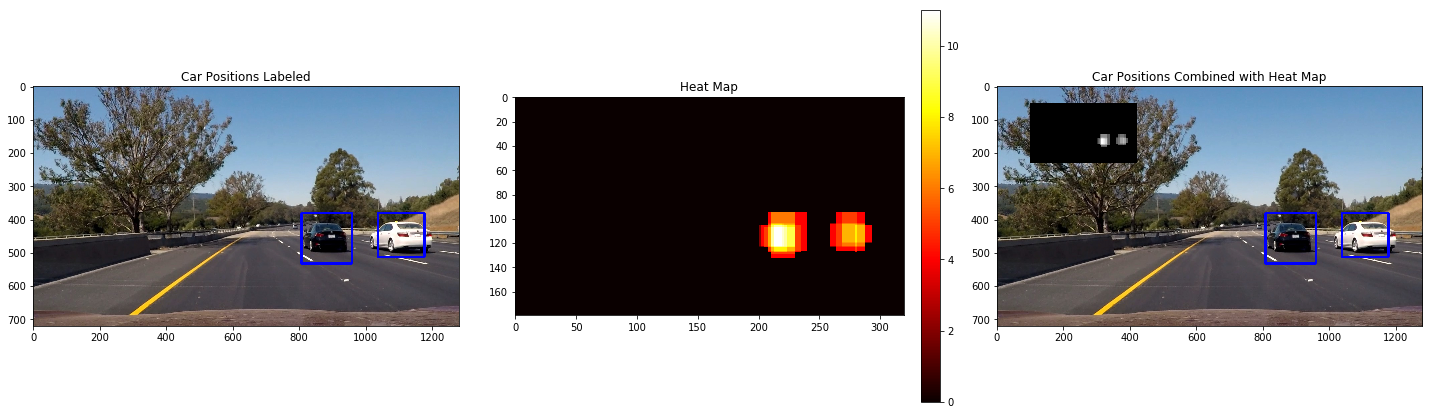

./test_images\test7.jpg


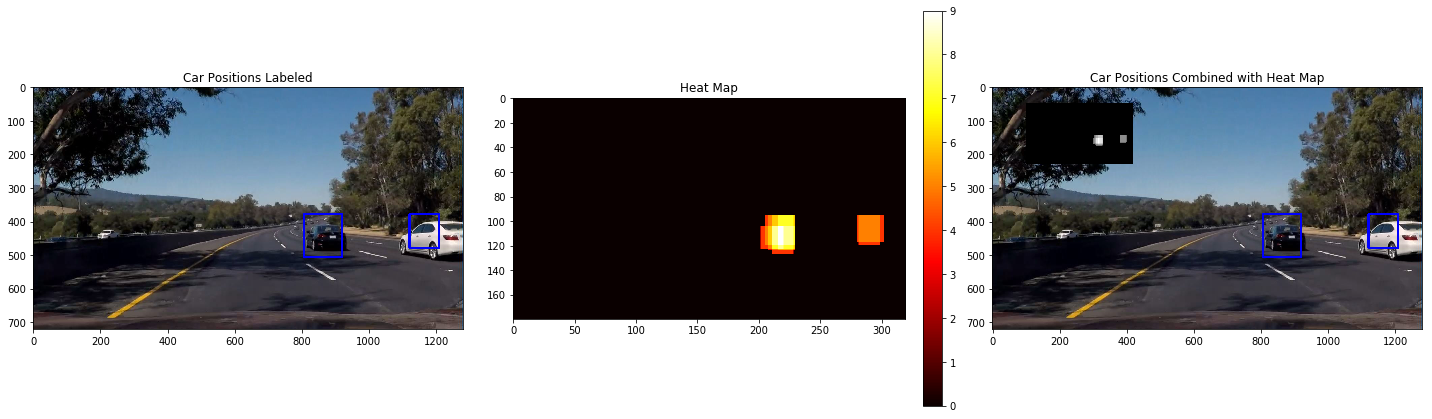

./test_images\test8.jpg


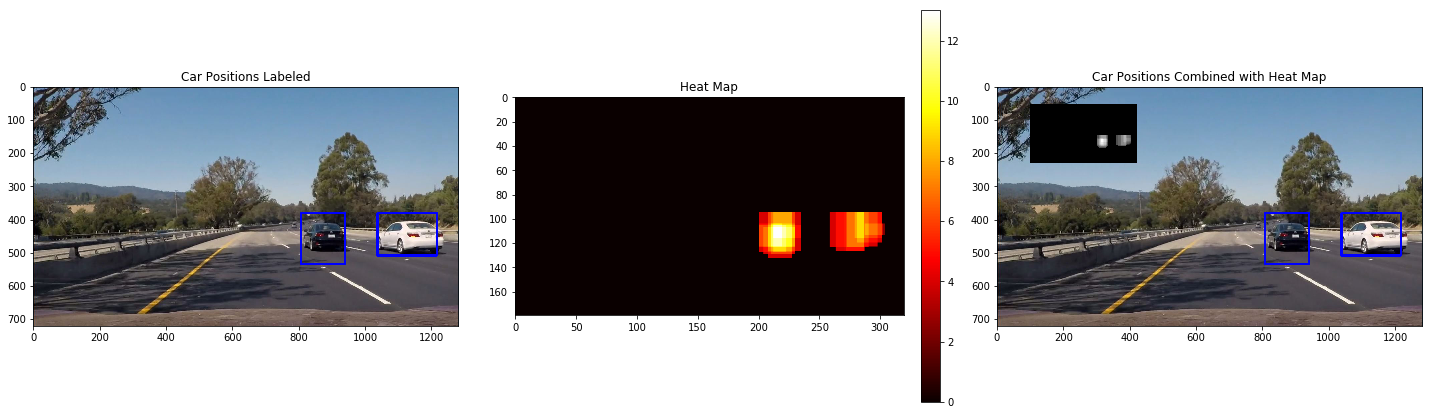

./test_images\test9.jpg


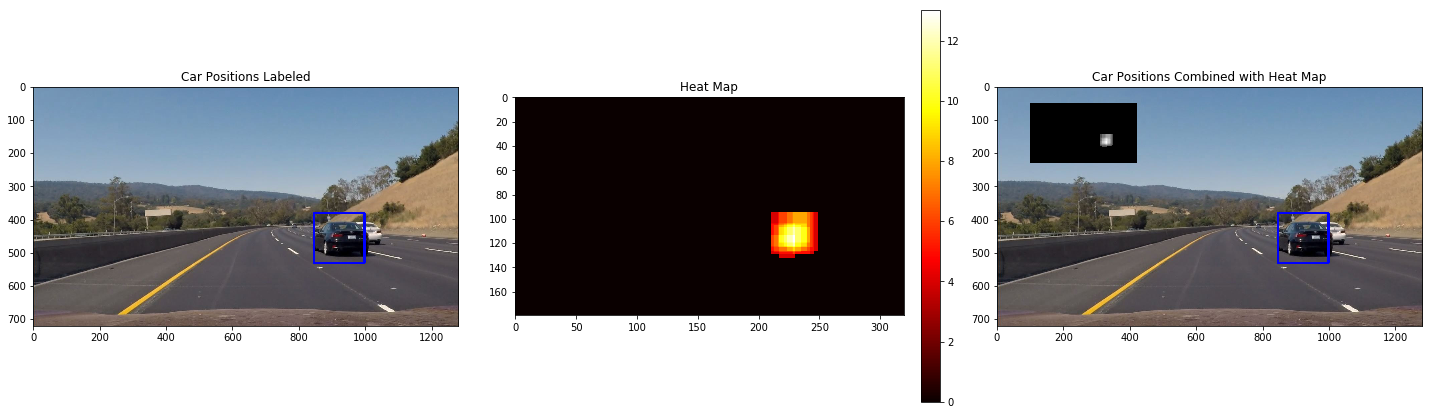

In [48]:
from scipy.ndimage.measurements import label
import glob

def process_image(img, colorspace = 'YUV', verbose=False):
       
    #ystart = 360
    ystart_list = np.array([380])
    #ystart_list = np.array([360, 390, 390, 390, 390, 330])
    #ystop = None
    ystop_list =  np.array([630])
    #ystop_list =  np.array([540, 490, 510, 530, 570, 630])
    #scale = 1.5
    #scale_list = [1.5]
    #scale_list = [1.0, 1.5, 1.8, 3.5]
    scale_list = np.array(range(1,10,1))*0.2+1
    #scale_list = (ystop_list - ystart_list)/64.0
    
    box_list = []

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    img_copy = np.copy(img)
    
    #for ystart, ystop, scale in zip(ystart_list, ystop_list, scale_list):
    for ystart, ystop in zip(ystart_list, ystop_list):
        for scale in scale_list:
            draw_img, box = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block,\
                            spatial_size = (size_reduced, size_reduced), hist_bins = nbins, color_space = colorspace)
            box_list = box_list + box
            #print(ystart, ystop, scale, box)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    mask = np.array(np.zeros_like(heat))
    mask[:, 320:] = 1
    heat = apply_threshold(heat, 3, mask)
    # Add to heatmap history list
    if len(heatmap_list)<heatmap_len_max:
        heatmap_list.append(heat)
    else:
        heatmap_list.pop(0)
        heatmap_list.append(heat)
    heat_average = np.zeros_like(heat)
    for item in heatmap_list:
        heat_average += item
    heat_average = heat_average/len(heatmap_list)
    #heat_average = apply_threshold(heat_average,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_average, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img_labeled = draw_labeled_bboxes(img_copy, labels)
    
    if verbose is True:
        fig = plt.figure(figsize=(20,10))
        plt.subplot(131)
        #plt.imshow(draw_img)
        #plt.title('Car Positions')
        plt.imshow(draw_img_labeled)
        plt.title('Car Positions Labeled')
        plt.subplot(132)
        heatmap = cv2.resize(heatmap, (320, 180))
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.subplot(133)
        offset_x, offset_y = 100, 50
        heatmap = heatmap / np.amax(heatmap) *255.0
        draw_img_labeled[offset_y: offset_y + 180, offset_x: offset_x+320, 0] = heatmap
        draw_img_labeled[offset_y: offset_y + 180, offset_x: offset_x+320, 1] = heatmap
        draw_img_labeled[offset_y: offset_y + 180, offset_x: offset_x+320, 2] = heatmap
        plt.imshow(draw_img_labeled)
        plt.title('Car Positions Combined with Heat Map')
        fig.tight_layout()
        plt.show()
    else:
        heatmap = cv2.resize(heatmap, (320, 180))
        offset_x, offset_y = 100, 50
        heatmap = heatmap / np.amax(heatmap) *255.0
        draw_img_labeled[offset_y: offset_y + 180, offset_x: offset_x+320, 0] = heatmap
        draw_img_labeled[offset_y: offset_y + 180, offset_x: offset_x+320, 1] = heatmap
        draw_img_labeled[offset_y: offset_y + 180, offset_x: offset_x+320, 2] = heatmap
    return draw_img_labeled

heatmap_list = []
#heatmap_len_max = 40
heatmap_len_max = 1

images = glob.glob('./test_images/test*.jpg')
#images = ['./test_images/test1.jpg']
#images = ['./output_images/test_frame_24.jpg']
#images = []
#for i in range(175,185,1):
#    images.append('./output_images/test_frame_'+str(i)+'.jpg')
for img_file in images[:]:
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img_file)
    process_image(img, colorspace = colorspace, verbose = True)

# Video Processing

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
white_output = './output_images/test_output.mp4'
directory = os.path.dirname(white_output)
if not os.path.exists(directory):
    os.mkdir(directory)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

#clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
clip1 = VideoFileClip("project_video.mp4")
#for idx, frame in enumerate(clip1.iter_frames()):
#    output_file_name = './output_images/test_frame_'+str(idx)+'.jpg'
#    cv2.imwrite(output_file_name,cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_images/test_output.mp4
[MoviePy] Writing video ./output_images/test_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [13:53<00:00,  1.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_output.mp4 

Wall time: 13min 54s
